Can we measure Burnout in salaried Staff? What is the ratio of break time to billable time?
Are Employees taking enough time off?

Does more time off improve Productivity in salaried employees?

Compare Time off hours between Salary and non-salary staff

How does billable hours for customers, vs non-billable hours for customers breakdown?

What are the types overhead?

How do hours worked vary by day of the week?

Are there days of the week where employees are more productive?

In [220]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

In [221]:
# //*** Define Global Values
g = {
    'obfuscate': {},
    'combined_df_filename' : 'combined.dat',
    'days_of_week' : ["Monday","Tuesday","Wednesday","Thursday","Friday"],
    'person' : {}
}
#"Saturday","Sunday"

# //*** Load keys.json
rawInput = ""
with open('keys.json', 'r') as readfile:
    for f in readfile.readlines():
        rawInput = rawInput + f + "\n"
readfile.close()

g['obfuscate'] = json.loads(rawInput)



# //*******************************************
# //*** Load Combined df - Master Data Frame
# //*******************************************
combined_df = pd.read_csv(g['combined_df_filename'])

# //*** Delete First Column, I believe is a CSV artifact
del combined_df[ combined_df.columns[0] ]

# //**** Convert Local Date to Date Time Format
# //**** Strip out exact time and keep date
combined_df['local_date'] = combined_df['local_date'].str.replace(" 00:00:00","")

# //*** Run conversion once, ie check for timestamp property in first value
# //*** Just a wee bit of fail safely
if "Timestamp" not in str(type(combined_df['local_date'][0])):
    # //**** Convert String to date
    dateCol = pd.to_datetime(combined_df['local_date'], format='%Y-%m-%d')
    
    combined_df['local_date'] = dateCol
    
    
    
    # //*** Build Days of the Week Column as an Integer
    combined_df['day_int'] = combined_df['local_date'].dt.dayofweek

    # //*** Build Day Column as a String [ Monday ~ Sunday ]
    # //*** Start With am empty list and convert 'day_int' column into a list of strings

    day_list = []

    date_dict = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}

    for x in range(0,len(combined_df['day_int'])):
        day_list.append(date_dict[combined_df['day_int'][x]])

    # //*** Convert day_list to Series and add as 'day column'
    combined_df['day'] = pd.Series(day_list)

In [222]:
print(combined_df.head(10))

  local_date  hours                    jobcode_1  \
0 2019-01-01   8.00                      Holiday   
1 2019-01-02   1.75                 Gabel Energy   
2 2019-01-02   1.08  ALTUS Architecture + Design   
3 2019-01-02   1.58                 Gabel Energy   
4 2019-01-02   1.25        BDE Architecture Inc.   
5 2019-01-03   2.50                 Gabel Energy   
6 2019-01-03   0.67                  Lunch Break   
7 2019-01-03   0.33                 Gabel Energy   
8 2019-01-03   0.58        BDE Architecture Inc.   
9 2019-01-03   0.17                 Gabel Energy   

                                  jobcode_2  \
0                                       NaN   
1                                       NaN   
2  19009 - Munson Residence and Guest House   
3                                       NaN   
4  17214 Walnut Creek Transit Village Phase   
5                                       NaN   
6                                       NaN   
7                                       NaN   
8  1

In [223]:
# //********************************************************************
# //*** Pandas Frequency from dataframe
# //********************************************************************
# //*** Productivity Data Frame: These Jobs make the money
billable_df = combined_df[combined_df['jobcode_2'].str.len() > 2]


#print(combined_df['jobcode_1'].value_counts().sort_values(ascending=False).head(10))
#print("######")
#print(billable_df['jobcode_1'].value_counts().sort_values(ascending=False).head(10))
#print("######")

# //*** get a value distribution of billable jobs
billable_value_count = billable_df['jobcode_1'].value_counts().sort_values(ascending=False)
print(billable_value_count)
# //********************************************************************
# //*** Build weighted values
# //********************************************************************
#print(f"{billable_value_count}")
#print(f"{jobcode1_value_count.index}")

# //*** Build a list of summed hours for each jobcode category
# //*** Loop through each billable jobcode to get the total hours for that job 
billable_hours_distribution = {}
for x in range(0,len(billable_value_count.index)):
    loop_key = billable_value_count.index[x]
    
    # //*** get total hours for each job
    billable_hours_distribution[loop_key] = combined_df[combined_df['jobcode_1'] == loop_key ]['hours'].sum()


# //*************************
# //*** Sort Billable Hours
# //*************************
# //*** https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
# //*** Builds a sorted dictionary
billable_hours_distribution = sorted(billable_hours_distribution.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
jobcode1_keys = []
jobcode1_values = []
# //*** Pull the sorted dictionary apart
for x in billable_hours_distribution:
    jobcode1_keys.append(x[0])
    jobcode1_values.append(x[1])

# //*** Reassemble as an ordered pandas series
billable_hours_distribution = pd.Series(index=jobcode1_keys, data=jobcode1_values)  



Pacific Gas & Electric Co.    1760
BDE Architecture Inc.         1562
Jarvis Architects              404
HOMEOWNER                      390
NORESCO                        346
                              ... 
Permit Drafting Solutions        1
Alex Smith, Architect            1
Bamcore                          1
Keene Builders                   1
K. Reimer & Co                   1
Name: jobcode_1, Length: 157, dtype: int64


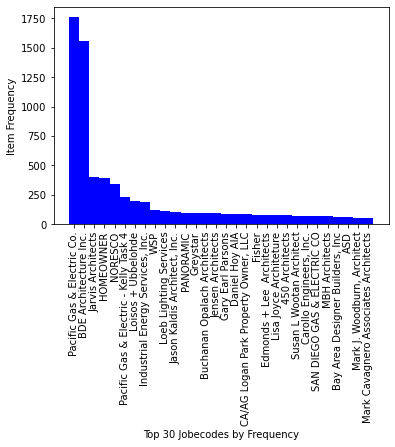

<Figure size 72x36000 with 0 Axes>

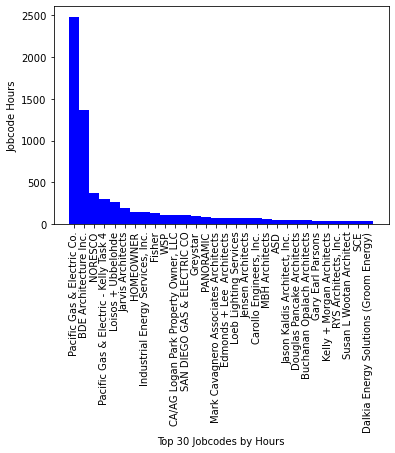

<Figure size 72x36000 with 0 Axes>

In [224]:
# //*** Plot By Job Frequency - Top 20
billable_value_count_top_30 = billable_value_count[0:30]

# //*** Histogram with matplotlib
plt.bar(billable_value_count_top_30.index.values, billable_value_count_top_30, 1, color='b')
#plt.tight_layout()

plt.xticks(billable_value_count_top_30.index.values, billable_value_count_top_30.index, rotation='vertical')
#plt.title(f"Biased Distribution\nMean: {round(resp['numkdhh'][resp['numkdhh'] > 0].mean(),2)}")
plt.xlabel('Top 30 Jobecodes by Frequency')
plt.ylabel('Item Frequency')
plt.figure(figsize=(1,500))
plt.show()

# //*** Plot by Total Job Hours - Top 20
billable_hours_distribution_top_20 = billable_hours_distribution[0:30]

# //*** Histogram with matplotlib
plt.bar(billable_hours_distribution_top_20.index.values, billable_hours_distribution_top_20, 1, color='b')
#plt.tight_layout()

plt.xticks(billable_hours_distribution_top_20.index.values, billable_hours_distribution_top_20.index, rotation='vertical')
#plt.title(f"Biased Distribution\nMean: {round(resp['numkdhh'][resp['numkdhh'] > 0].mean(),2)}")
plt.xlabel('Top 30 Jobcodes by Hours')
plt.ylabel('Jobcode Hours')
plt.figure(figsize=(1,500))
plt.show()



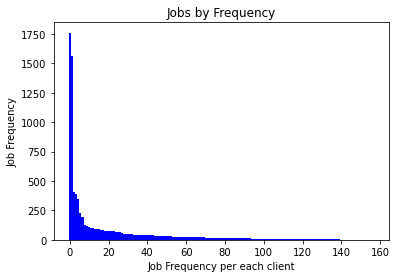

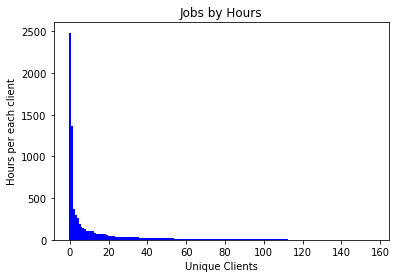

In [225]:
# //*** Build 
qlist = []
for x in range(0,len(billable_hours_distribution)):
    qlist.append(x)
    
# //*** Histogram with matplotlib
plt.bar(qlist, billable_value_count, 1, color='b')
#plt.tight_layout()

#plt.xticks(qlist, billable_value_count.index, rotation='vertical')
#plt.title(f"Biased Distribution\nMean: {round(resp['numkdhh'][resp['numkdhh'] > 0].mean(),2)}")
plt.title(f"Jobs by Frequency")
plt.xlabel('Job Frequency per each client')
plt.ylabel('Job Frequency')
plt.show()



# //*** Build 
qlist = []
for x in range(0,len(billable_hours_distribution)):
    qlist.append(x)
# //*** Histogram with matplotlib
plt.bar(qlist, billable_hours_distribution, 1, color='b')
#plt.tight_layout()

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"Jobs by Hours")
plt.xlabel('Unique Clients')
plt.ylabel('Hours per each client')
plt.show()

In [226]:
# //*** Look at Customer Hours Distribution
print(f"Mean Billable Hours: {billable_hours_distribution.mean()}")
print(f"Median Billable Hours: {billable_hours_distribution.median()}")

companies_greater_than_billable_mean = billable_hours_distribution[ billable_hours_distribution > billable_hours_distribution.mean()]
companies_less_than_billable_mean = billable_hours_distribution[ billable_hours_distribution < billable_hours_distribution.mean()]
companies_greater_than_billable_median = billable_hours_distribution[ billable_hours_distribution > billable_hours_distribution.median()]
print(f"Number of Companies greater than the mean: {len(companies_greater_than_billable_mean)}")
print(f"Percentage of hours: {companies_greater_than_billable_mean.sum() / billable_hours_distribution.sum() }")
print(f"Percentage of companites: { len(companies_greater_than_billable_mean) / len(billable_hours_distribution) }")

print(f"Number of Companies greater than the median: {len(companies_greater_than_billable_median)}")
print(f"{companies_greater_than_billable_mean.sum()} {companies_less_than_billable_mean.sum()} ")
print(billable_hours_distribution.sum())

Mean Billable Hours: 49.92464968152864
Median Billable Hours: 9.04
Number of Companies greater than the mean: 21
Percentage of hours: 0.812231681629768
Percentage of companites: 0.1337579617834395
Number of Companies greater than the median: 78
6366.41 1471.76 
7838.170000000001


In [227]:
def build_pmf(input_series):
    output_series = input_series.copy()
    total_values = input_series.sum()
    for value,freq in output_series.items():
        #print(f"{value} {freq} {total_values} {freq/total_values}")
        output_series.loc[value] = freq/total_values
    return output_series

def getName(input_string):
    return g['obfuscate'][input_string]['fname']

# //*** Container class for storing employee values
class Person():
    
    def add_breaks(self,input_key,input_value):
        self.breaks[input_key] = input_value
    
    def __init__(self,input_hname,input_fname):
        self.totals = {}
        self.breaks = {}
        self.fname = input_fname # //**** Actual First Name
        self.hname = input_hname # //**** Hidden Name ie EMP_?
    def __str__(self):
        out = ""
        out += f"{self.hname} : {self.fname}\n"
        out += "Totals:\n"
        for key,value in self.totals.items():
            # //*** Round Float values
            if "float64" in str(type(value)):
                out += f"\t{key} - {round(value,2)} \n"
            elif "dict" in str(type(value)):
                out += f"\t{key}: \n"
                for key_lvl2, value_lvl2 in value.items():
                    out += f"\t\t{key_lvl2} - {round(value_lvl2,2)} \n"                    
            else:
                out += f"\t{key} - {value} \n"
        return out

In [228]:
#print(len(combined_df[ combined_df['jobcode_1'].str.contains("Gabel") ] ) ) 
#print(len(combined_df[ combined_df['class'].str.contains("Overhead",na=False) ] ) ) 
#print(combined_df['class'].unique() ) 
#print( combined_df[ combined_df['jobcode_1'].str.contains("Gabel",na=False) ] )


In [229]:

# //*** Extract Employee Breaks and Offtime.
# //*** This was straightforward except for everyone BUT the owner, who did not classify breaks the same as
# //*** the employees
combined_employee_breaks = combined_df[ combined_df['activity'].isna() ]
combined_employee_breaks = combined_employee_breaks[ combined_employee_breaks['billable'].isna()]
combined_employee_breaks = combined_employee_breaks[ combined_employee_breaks['jobcode_1'] != "K2D Consulting Engineers"]
print(combined_employee_breaks['jobcode_1'].unique())

combined_employee_breaks_salary_1 = combined_employee_breaks[combined_employee_breaks['salary'] == 1 ]
combined_employee_breaks_salary_0 = combined_employee_breaks[combined_employee_breaks['salary'] == 0 ]



# //*** Unique List of Employee Names
salary_employees = combined_employee_breaks_salary_1['emp_name'].unique()
print(f"salary_employees {salary_employees}")

# //*** Empkoyee offtime jodcodes
break_jobcodes = combined_employee_breaks['jobcode_1'].unique()
print(f"break_jobcodes {break_jobcodes}")

employees = {'salary' : {'names' : salary_employees }, 'hourly' : {} }

# //*** Get Yearly totals for salaried employees


# //******************************
# //*** For Each Employee as emp
# //******************************
for emp in salary_employees:
    
    # //*** Dictionary structure to hold employees combined hours for later use in some fashion
    thisPerson = Person(emp,g['obfuscate'][emp]['fname'])
    
    # //*** Get Employee entries that are billable = isna  - These are break
    loop_combined_emp = combined_employee_breaks[combined_employee_breaks['emp_name'] == emp ]
    
    # //*** get Employee entries for Overhead work
    loop_gabel_df = combined_df[ combined_df['jobcode_1'].str.contains("Gabel",na=False) ]
    
    loop_overhead_employee_df = loop_gabel_df[ loop_gabel_df['emp_name'] == emp ]
    
    
    # //*** Build jobcode values per employee
    for jobcode in break_jobcodes:
        loop_jobcode_hours = round( loop_combined_emp[ loop_combined_emp['jobcode_1'] == jobcode]['hours'].sum(), 2)
        #thisEmp['breaks'][jobcode] = loop_jobcode_hours
        #thisPerson.add_breaks(jobcode,loop_jobcode_hours)
        thisPerson.breaks[jobcode] = loop_jobcode_hours
        
    # //*** Combine Lunch breaks/Rest Breaks for daily breaks
    
    total_break_time =  thisPerson.breaks['Lunch Break'] + thisPerson.breaks['Rest Break']
    total_vacation_time = thisPerson.breaks['Holiday'] + thisPerson.breaks['Vacation']
    thisPerson.breaks['combined_break_time'] = total_break_time
    thisPerson.breaks['combined_vaction'] = total_vacation_time
    
    
    # //*** Build Employee Total Hours Logged
    total_yearly_hours = combined_df[combined_df['emp_name'] == emp ]['hours'].sum()
    
    thisPerson.totals['hours'] = total_yearly_hours
    
    # //******************************************************
    # //*** Get emp client Billable and non-billable hours
    # //******************************************************
    
    # //*** Get All employee records
    total_customer_hours_df = combined_df[combined_df['emp_name'] == emp ]
    
    # //*** jobcode_2 indicates productive billable customer work
    total_customer_hours_df = total_customer_hours_df[total_customer_hours_df['jobcode_2'].str.len() > 2]
   
    # //*** These are hours attributed to working on customer (ie billable) hours
    total_productive_hours = total_customer_hours_df['hours'].sum()
    
    #productive_hours_day_distribution = total_customer_hours_df['hours']
    
    # //**** Build Total Hours by Day of the Week,
    # //*** Get All entries by Day of the week
    
    customer_hours_distribution = {}
    overhead_hours_distribution = {}
    productivity_hours_distribution = {}
    for x in g['days_of_week']:
        # //*** Build distribution of Customer hours by day
        loop_customer_day_df = total_customer_hours_df[total_customer_hours_df['day'] == x ]
        loop_customer_day_hours_sum = loop_customer_day_df['hours'].sum()
        customer_hours_distribution[x] = loop_customer_day_hours_sum
        
        # //*** Build distribution of Overhead hours by day
        loop_overhead_day_df = total_customer_hours_df[total_customer_hours_df['day'] == x ]
        
        loop_overhead_day_df = loop_overhead_employee_df[loop_overhead_employee_df['day'] == x ]
        loop_overhead_day_hours_sum = loop_overhead_day_df['hours'].sum()
        overhead_hours_distribution[x] = loop_overhead_day_hours_sum
        
        productivity_hours_distribution[x] = loop_overhead_day_hours_sum + loop_customer_day_hours_sum

    
    
    #print (total_customer_hours_df['day_int'].value_counts().sort_index())
    
        
    #.rename(index=["a","b","c","d","e","f","g"]) 
    
    overhead_hours = total_yearly_hours - total_productive_hours - total_break_time - total_vacation_time

    # //*** Convert vacation hours to days
    vacation_days = total_vacation_time / 8
    #260 - Work days /year
    # //*** Measure average Productivity per day worked:
    # //*** 260 Work Days - Vacation days
    annual_workdays = 260 - vacation_days
    average_workday_hours = (overhead_hours + total_productive_hours) / annual_workdays

    # //*** Measure length of the work day (butt in chair time) productivity + breaks
    
    average_day_length_hours = (overhead_hours + total_productive_hours + total_break_time) / annual_workdays
    
    thisPerson.totals['productivity_hours'] = overhead_hours + total_productive_hours
    thisPerson.totals['customer_hours'] = total_productive_hours
    thisPerson.totals['overhead_hours'] = overhead_hours
    thisPerson.totals['average_productive_hours'] = average_workday_hours
    thisPerson.totals['average_day_length_hours'] = average_day_length_hours
    thisPerson.totals['productivity_hours_distribution'] = productivity_hours_distribution
    thisPerson.totals['customer_hours_distribution'] = customer_hours_distribution
    thisPerson.totals['overhead_hours_distribution'] = overhead_hours_distribution
    thisPerson.totals['vacation_hours'] = total_vacation_time
    thisPerson.totals['break_hours'] = total_break_time
    
    
    print(thisPerson)
    
    g['person'][emp] = thisPerson
    
    #//*** END Each Employee
    


['Holiday' 'Lunch Break' 'Rest Break' 'PTO' 'Vacation']
salary_employees ['EMP_1' 'EMP_2' 'EMP_6' 'EMP_8' 'EMP_11' 'EMP_12']
break_jobcodes ['Holiday' 'Lunch Break' 'Rest Break' 'PTO' 'Vacation']
EMP_1 : Arielle
Totals:
	hours - 2024.72 
	productivity_hours - 1507.74 
	customer_hours - 818.76 
	overhead_hours - 688.98 
	average_productive_hours - 6.56 
	average_day_length_hours - 7.76 
	productivity_hours_distribution: 
		Monday - 263.66 
		Tuesday - 294.73 
		Wednesday - 318.16 
		Thursday - 279.56 
		Friday - 264.61 
	customer_hours_distribution: 
		Monday - 169.0 
		Tuesday - 154.22 
		Wednesday - 186.3 
		Thursday - 163.55 
		Friday - 121.51 
	overhead_hours_distribution: 
		Monday - 94.66 
		Tuesday - 140.51 
		Wednesday - 131.86 
		Thursday - 116.01 
		Friday - 143.1 
	vacation_hours - 240.0 
	break_hours - 276.98 

EMP_2 : Cynthia
Totals:
	hours - 2359.65 
	productivity_hours - 2106.07 
	customer_hours - 143.46 
	overhead_hours - 1962.61 
	average_productive_hours - 8.88 
	avera

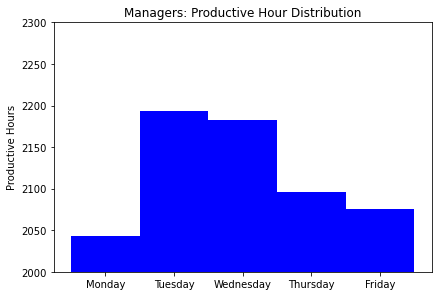

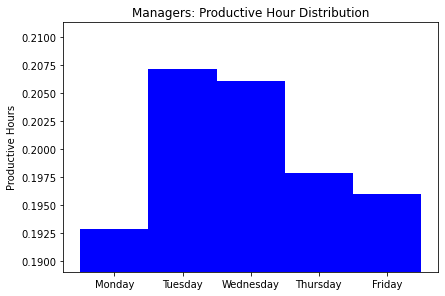

In [230]:
# // *** Manager Total Productivity by Day
manager_hour_distribution = {}

for key_person, value_person in g['person'].items():
    for key_week, value_hours in value_person.totals['productivity_hours_distribution'].items():
        #print(f"{key_week} : {value_hours}")
        if key_week not in manager_hour_distribution.keys():
            manager_hour_distribution[key_week] = value_hours
        else:
            manager_hour_distribution[key_week] += value_hours

manager_hour_distribution = pd.Series(index=manager_hour_distribution.keys(), data=list(manager_hour_distribution.values()))

manager_hour_distribution_pmf = build_pmf(manager_hour_distribution)

           
# //*** Histogram with matplotlib
plt.bar(manager_hour_distribution.index, manager_hour_distribution, 1, color='b')
plt.tight_layout()
plt.ylim(2000,2300)

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"Managers: Productive Hour Distribution")
#plt.xlabel('Top 30 Jobcodes by Hours')
plt.ylabel('Productive Hours')
#plt.figure(figsize=(1,500))
plt.show()

# //*** Histogram with matplotlib
plt.bar(manager_hour_distribution_pmf.index, manager_hour_distribution_pmf, 1, color='b')
plt.tight_layout()
plt.ylim(manager_hour_distribution_pmf.min() *.98 ,manager_hour_distribution_pmf.max() * 1.02)

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"Managers: Productive Hour Distribution")
#plt.xlabel('Top 30 Jobcodes by Hours')
plt.ylabel('Productive Hours')
#plt.figure(figsize=(1,500))
plt.show()


In [273]:
#print(combined_df[combined_df['day'] == "Monday" ] )

# //*** Productivity Data Frame: These Jobs make the money
billable_df = combined_df[combined_df['jobcode_2'].str.len() > 2]



# //*** Overhead Work: It's Work that's gotta get done
overhead_df = combined_df[ combined_df['jobcode_1'].str.contains("Gabel",na=False) ]

#print(productive_df['jobcode_1'].unique())
#print(overhead_df['jobcode_1'].unique())

total_employee_hours_distribution = []
billable_employee_hours_distribution = []
overhead_employee_hours_distribution = []
salary_billable_hours_distribution = []
salary_overhead_hours_distribution = []
hourly_billable_hours_distribution = []
hourly_overhead_hours_distribution = []

for x in g['days_of_week']:
    
    # //*** Get income hours for all Employees by day
    loop_billable = billable_df[billable_df['day'].str.contains(x) ]['hours'].sum()
    loop_billable_salary_df = billable_df[billable_df['day'].str.contains(x) ]
    
    # //*** Salary Billable Hours
    loop_salary_billable =loop_billable_salary_df[loop_billable_salary_df['salary'] == 1]['hours'].sum()

    # //*** Hourly Billable Hours
    loop_hourly_billable = loop_billable_salary_df[loop_billable_salary_df['salary'] == 0]['hours'].sum()
    
    
    
    
    
    # //*** Get Overhead hours for all Employees by day
    loop_overhead = overhead_df[overhead_df['day'].str.contains(x) ]['hours'].sum()
    loop_overhead_df = overhead_df[overhead_df['day'].str.contains(x) ]

    # //*** Salary Billable Hours by day of week
    loop_salary_overhead =loop_overhead_df[loop_overhead_df['salary'] == 1]['hours'].sum()
    
    # //*** Hourly Billable Hours
    loop_hourly_overhead =loop_overhead_df[loop_overhead_df['salary'] == 0]['hours'].sum()
    
    
    #print(f"{loop_salary_billable} - {loop_hourly_billable} : {loop_salary_overhead} - {loop_hourly_overhead}")
    
    # //*** Add to the lists
    total_employee_hours_distribution.append(loop_billable + loop_overhead)
    billable_employee_hours_distribution.append(loop_billable)
    overhead_employee_hours_distribution.append(loop_overhead)
    salary_billable_hours_distribution.append(loop_salary_billable) 
    salary_overhead_hours_distribution.append(loop_salary_overhead)
    hourly_billable_hours_distribution.append(loop_hourly_billable)
    hourly_overhead_hours_distribution.append(loop_hourly_overhead)


total_employee_hours_distribution = pd.Series( index=g['days_of_week'], data= total_employee_hours_distribution)
total_employee_hours_distribution_pmf = build_pmf(total_employee_hours_distribution)

billable_employee_hours_distribution = pd.Series(index=g['days_of_week'], data= billable_employee_hours_distribution)
billable_employee_hours_distribution_pmf = build_pmf(billable_employee_hours_distribution)

overhead_employee_hours_distribution = pd.Series(index=g['days_of_week'], data= overhead_employee_hours_distribution)
overhead_employee_hours_distribution_pmf = build_pmf(overhead_employee_hours_distribution)

salary_billable_hours_distribution = pd.Series(index=g['days_of_week'], data= salary_billable_hours_distribution)
salary_billable_hours_distribution = build_pmf(salary_billable_hours_distribution)

salary_overhead_hours_distribution = pd.Series(index=g['days_of_week'], data= salary_overhead_hours_distribution)
salary_overhead_hours_distribution = build_pmf(salary_overhead_hours_distribution)

hourly_billable_hours_distribution = pd.Series(index=g['days_of_week'], data= hourly_billable_hours_distribution)
hourly_billable_hours_distribution = build_pmf(hourly_billable_hours_distribution)

hourly_overhead_hours_distribution = pd.Series(index=g['days_of_week'], data= hourly_overhead_hours_distribution)
hourly_overhead_hours_distribution = build_pmf(hourly_overhead_hours_distribution)

print(total_employee_hours_distribution_pmf)
print(billable_employee_hours_distribution_pmf)
print(overhead_employee_hours_distribution_pmf)    
print(salary_billable_hours_distribution)    
print(salary_overhead_hours_distribution)    
print(hourly_billable_hours_distribution)    
print(hourly_overhead_hours_distribution)    


    
    
    

Monday       0.190218
Tuesday      0.208559
Wednesday    0.200766
Thursday     0.201006
Friday       0.199450
dtype: float64
Monday       0.188865
Tuesday      0.199263
Wednesday    0.205482
Thursday     0.229066
Friday       0.177324
dtype: float64
Monday       0.191220
Tuesday      0.215444
Wednesday    0.197274
Thursday     0.180226
Friday       0.215836
dtype: float64
Monday       0.186169
Tuesday      0.203030
Wednesday    0.204613
Thursday     0.228490
Friday       0.177698
dtype: float64
Monday       0.198359
Tuesday      0.210485
Wednesday    0.207238
Thursday     0.173241
Friday       0.210677
dtype: float64
Monday       0.193547
Tuesday      0.192722
Wednesday    0.206991
Thursday     0.230065
Friday       0.176675
dtype: float64
Monday       0.181159
Tuesday      0.222433
Wednesday    0.183230
Thursday     0.190070
Friday       0.223108
dtype: float64


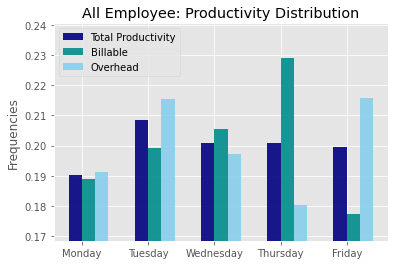

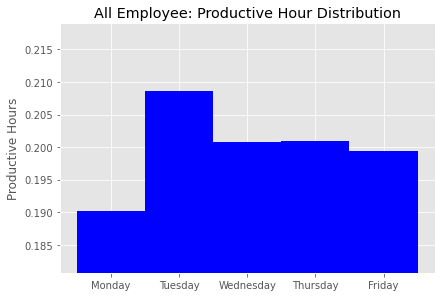

In [262]:
#plt.style.use('ggplot')
n = 5
var1 = total_employee_hours_distribution_pmf
var2 = billable_employee_hours_distribution_pmf
var3 = overhead_employee_hours_distribution_pmf
fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.2
opacity = 0.9
ax.bar(index, var1, bar_width, alpha=opacity, color='navy',label='Total Productivity')
                
ax.bar(index+bar_width, var2, bar_width, alpha=opacity, color='darkcyan', label='Billable')
ax.bar(index+(bar_width*2), var3, bar_width, alpha=opacity, color='skyblue', label='Overhead')
plt.ylim(billable_employee_hours_distribution_pmf.min() * .95,billable_employee_hours_distribution_pmf.max() * 1.05)
#ax.set_xlabel('Seasons')
ax.set_ylabel('Frequencies')
plt.title(f"All Employee: Productivity Distribution")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(g['days_of_week'])
ax.legend()
plt.show()


# //*** Histogram with matplotlib
plt.bar(total_employee_hours_distribution_pmf.index, total_employee_hours_distribution_pmf, 1, color='b')
plt.tight_layout()
plt.ylim(total_employee_hours_distribution_pmf.min() * .95,total_employee_hours_distribution_pmf.max() * 1.05)

#plt.xticks(jobcode1_value_count_top_20.index.values, jobcode1_value_count_top_20.index, rotation='vertical')
plt.title(f"All Employee: Productive Hour Distribution")
#plt.xlabel('Top 30 Jobcodes by Hours')
plt.ylabel('Productive Hours')
#plt.figure(figsize=(1,500))
plt.show()

In [233]:
logged_rest_periods = combined_df[combined_df['billable'].isna() ]
#print(logged_rest_periods)
logged_rest_periods['jobcode_1'].unique()
g['rest_period_dict'] = {}
g['rest_period_reverse_dict'] = {}
counter = 1
for x in logged_rest_periods['jobcode_1'].unique():
    g['rest_period_dict'][x] = counter
    g['rest_period_reverse_dict'][counter] = x
    counter = counter + 1

print(g['rest_period_dict'])
print(g['rest_period_reverse_dict'])

jobID = logged_rest_periods['jobcode_1']

for find,replace in g['rest_period_dict'].items():
    print(f"{find} {replace}")
    jobID = jobID.str.replace(find,str(replace))
print(jobID)

{'Holiday': 1, 'Lunch Break': 2, 'Rest Break': 3, 'PTO': 4, 'Vacation': 5, 'K2D Consulting Engineers': 6}
{1: 'Holiday', 2: 'Lunch Break', 3: 'Rest Break', 4: 'PTO', 5: 'Vacation', 6: 'K2D Consulting Engineers'}
Holiday 1
Lunch Break 2
Rest Break 3
PTO 4
Vacation 5
K2D Consulting Engineers 6
0        1
6        2
15       2
25       2
29       3
        ..
23256    2
23258    3
23271    3
23273    3
23279    3
Name: jobcode_1, Length: 3991, dtype: object


In [234]:
# //*** Not So Dead Ends
#print(jobcode1_value_count.str.contains('Gabel',regex=False))
#billable_jobs_gabel = combined_df[combined_df['jobcode_1'].str.contains('Gabel',regex=False) == False  ]

#combined_df[combined_df.billable =='Yes']
#print(billable_jobs_gabel)

# //*** Billable is not a measure productivity.
# //*** It is a matter of invoicing
#combined_billable = combined_df[ combined_df['billable'] == 'Yes' ]
#combined_non_billable = combined_df[ combined_df['billable'] == 'No' ]
